In [1]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from keras.models import *
from keras.models import Sequential, Model  # Importar Model para modelos funcionales
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import numpy as np
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Input  # Importar Input para definir la entrada
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import pickle 

d:\guille\Python\Proyecto final\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
patient_data = pd.read_csv('PatientCorePopulatedTable.txt', sep='\t')
labs_data = pd.read_csv('LabsCorePopulatedTable.txt', sep='\t')
diagnosis_data = pd.read_csv('AdmissionsDiagnosesCorePopulatedTable.txt', sep='\t')

In [3]:
labs_data["P+A"] = labs_data["PatientID"] + labs_data["AdmissionID"].map(str)
diagnosis_data["P+A"] = diagnosis_data["PatientID"] + diagnosis_data["AdmissionID"].map(str)

In [4]:
labs_data_pivote = labs_data.pivot_table(index='P+A', columns=['LabName','LabUnits'], values='LabValue', fill_value=-100)


In [5]:
#labs_data_pivote.isin([-100]).any().any()

In [6]:
labs_data_pivote.columns = pd.MultiIndex.from_tuples(labs_data_pivote.columns, names=['LabName', 'LabUnits'])

# Concatenar los nombres de los niveles y establecer como índice único
labs_data_pivote.columns = labs_data_pivote.columns.get_level_values('LabName') + ' (' + labs_data_pivote.columns.get_level_values('LabUnits') + ')'

In [7]:
# Primero, fusionamos los dos primeros DataFrames
merged_df = pd.merge(labs_data_pivote, diagnosis_data, on='P+A')

In [8]:
# Luego, fusionamos el resultado con el tercer DataFrame
merged_df = pd.merge(merged_df, patient_data, on='PatientID', how='outer')

In [9]:
# Calcular la Edad
merged_df['Edad'] = 2024 - pd.to_datetime(merged_df['PatientDateOfBirth']).dt.year

# Eliminar Columnas No Necesarias
merged_df.drop(['P+A', 'PatientDateOfBirth', 'PatientID', 'AdmissionID', 'PrimaryDiagnosisDescription',
              ], axis=1, inplace=True)

In [10]:
# Función para convertir columnas a numéricas y aplicar encoding si es necesario
def convertir_columnas(df):
    le = LabelEncoder()
    for columna in df.columns:
        # Intenta convertir a numérico
        try:
            df[columna] = pd.to_numeric(df[columna])
        except ValueError:
                df[columna] = le.fit_transform(df[columna])
    return df

In [11]:
# Aplica la función al DataFrame
merged_df = convertir_columnas(merged_df)

In [12]:
merged_df

,CBC: ABSOLUTE LYMPHOCYTES (%),CBC: ABSOLUTE NEUTROPHILS (%),CBC: BASOPHILS (k/cumm),CBC: EOSINOPHILS (k/cumm),CBC: HEMATOCRIT (%),CBC: HEMOGLOBIN (gm/dl),CBC: LYMPHOCYTES (k/cumm),CBC: MCH (pg),CBC: MCHC (g/dl),CBC: MEAN CORPUSCULAR VOLUME (fl),...,URINALYSIS: RED BLOOD CELLS (rbc/hpf),URINALYSIS: SPECIFIC GRAVITY (no unit),URINALYSIS: WHITE BLOOD CELLS (wbc/hpf),PrimaryDiagnosisCode,PatientGender,PatientRace,PatientMaritalStatus,PatientLanguage,PatientPopulationPercentageBelowPoverty,Edad
0,28.300000,70.550000,0.033333,0.366667,42.150000,17.750000,-100.000000,28.250000,32.150000,86.400000,...,1.580000,1.0,2.300000,1170,1,3,1,0,14.63,70
1,23.650000,72.033333,0.033333,0.450000,43.700000,12.000000,1.450000,29.866667,37.866667,89.500000,...,2.200000,1.0,3.350000,1775,1,3,1,0,14.63,70
2,29.950000,69.650000,0.200000,0.400000,38.650000,12.466667,2.833333,34.925000,34.075000,76.900000,...,1.766667,1.0,1.833333,69,1,3,1,0,14.63,70
3,22.918750,70.061538,0.128571,0.414286,40.033333,14.042857,2.806250,33.658333,34.506667,81.737500,...,2.050000,1.0,3.054545,1193,1,3,1,0,14.63,70
4,25.880000,67.377778,0.110000,0.350000,42.960000,14.033333,2.611111,32.345455,34.070000,83.072727,...,1.760000,1.0,3.260000,1188,1,3,1,0,14.63,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36138,28.350000,66.180000,0.125000,0.340000,40.888889,14.137500,2.657143,29.466667,34.300000,81.788889,...,1.812500,1.0,2.800000,368,1,2,2,1,15.08,78
36139,27.466667,72.600000,0.072727,0.300000,38.057143,13.954545,2.737500,30.428571,35.818182,84.527273,...,2.500000,1.0,3.981818,1721,1,2,2,1,15.08,78
36140,25.912500,73.966667,0.075000,0.387500,37.650000,16.450000,2.962500,29.887500,35.528571,86.875000,...,1.433333,1.0,2.657143,620,1,2,2,1,15.08,78
36141,25.725000,72.500000,0.100000,0.433333,48.166667,15.550000,2.200000,29.833333,32.800000,95.700000,...,1.633333,1.0,3.600000,253,1,2,2,1,15.08,78


In [13]:
merged_df.to_csv('merged_df.csv', index=False)

In [14]:
counts = merged_df["PrimaryDiagnosisCode"].value_counts()

cumsum = np.cumsum(counts)

for top, num in enumerate(cumsum):
    if num >= merged_df.shape[0]/8:
        print(top, num)
        break

217 4527


In [15]:
counts

PrimaryDiagnosisCode
2523    28
565     26
2148    26
1613    26
1372    26
        ..
957      4
1634     4
160      4
2624     3
2091     2
Name: count, Length: 2625, dtype: int64

### DEFINICIÓN DE TRAIN Y TEST

In [16]:
# Separar X e Y
X = merged_df.drop(['PrimaryDiagnosisCode'], axis=1)
y = merged_df['PrimaryDiagnosisCode']

# Convertir las etiquetas de string a int
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Convertir las etiquetas categóricas a one-hot encoding
y = to_categorical(y)

# División de los Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Función para codificar por frecuencia
class FrequencyEncoder:
    def fit(self, X, y=None):
        self.frequencies = {col: X[col].value_counts().to_dict() for col in X.columns}
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.frequencies[col]).fillna(0)
        return X_transformed

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Separar X e Y
X = merged_df.drop(['PrimaryDiagnosisCode'], axis=1)
y = merged_df['PrimaryDiagnosisCode']

# Convertir las etiquetas de string a int
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Convertir las etiquetas categóricas a one-hot encoding
y = to_categorical(y)

# Identificar columnas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns

# Decidir qué columnas usar para OneHotEncoder y cuáles para FrequencyEncoder
onehot_cols = [col for col in categorical_cols if X[col].nunique() < 10]  # Ejemplo: columnas con menos de 10 categorías
freq_cols = [col for col in categorical_cols if X[col].nunique() >= 10]

# Crear preprocesador para las columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_cols),
        ('freq', FrequencyEncoder(), freq_cols)
    ],
    remainder='passthrough'  # Para dejar las columnas numéricas tal cual
)

# Aplicar el preprocesador a los datos
X_transformed = preprocessor.fit_transform(X)

# División de los Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verificar la forma de los datos
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")


Forma de X_train: (28914, 41)
Forma de X_test: (7229, 41)
Forma de y_train: (28914, 2625)
Forma de y_test: (7229, 2625)


In [18]:
y.shape[1]

2625

### GRID SEARCH

In [19]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier



# # Función para crear el modelo, requerida para KerasClassifier
# def create_model(optimizer='adam', activation='relu'): # rmsprop
#     model = Sequential([
#         Input(shape=(X_train.shape[1],)),
#         Dense(512, activation=activation, kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(256, activation=activation, kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(128, activation=activation, kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(64, activation=activation, kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(32, activation=activation, kernel_regularizer=l2(0.001)),
#         Dropout(0.4),
#         Dense(y_train.shape[1], activation='softmax')
#     ])
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Crear el modelo KerasClassifier
# model = KerasClassifier(model=create_model, verbose=0)

# # Definir la cuadrícula de parámetros
# param_grid = {
#     'optimizer': ['rmsprop', 'adam'],
#     #'activation': ['relu', 'tanh'],
#     'batch_size': [16, 32, 64, 128],
#     'epochs': [10, 20, 30, 50]
# }

# # Crear GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)

# # Resultados
# print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) con: %r" % (mean, stdev, param))

In [20]:
# print(model.get_params().keys())

### VISUALIZAR GRIDSEARCH

In [21]:
# # Convertir los resultados de GridSearchCV en un DataFrame
# results_df = pd.DataFrame(grid_result.cv_results_)

# # Filtrar las columnas que contienen los puntajes medios y los parámetros
# results_df = results_df.filter(regex='(mean_test_score|param_)')

# # Crear una nueva columna que combine los valores de los parámetros para facilitar la visualización
# results_df['params_str'] = results_df.apply(lambda row: f"bs={row['param_batch_size']}, e={row['param_epochs']}, opt={row['param_optimizer']}", axis=1)

# # Ordenar los resultados por el puntaje medio de prueba
# results_df.sort_values('mean_test_score', ascending=False, inplace=True)

# # Crear un gráfico de barras
# plt.figure(figsize=(12, 6))
# plt.barh(results_df['params_str'], results_df['mean_test_score'], color='skyblue')
# plt.xlabel('Puntaje Medio de Prueba')
# plt.ylabel('Hiperparámetros')
# plt.title('Rendimiento de los Hiperparámetros en GridSearchCV')
# plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el mejor puntaje en la parte superior
# plt.show()


In [22]:
# # Convertir los resultados de GridSearchCV en un DataFrame
# grid_results = pd.DataFrame(grid_result.cv_results_)

# # Seleccionar las columnas de interés
# columns_of_interest = ['param_optimizer', 'param_batch_size', 'param_epochs', 'mean_test_score']

# # Filtrar el DataFrame
# grid_filtered = grid_results[columns_of_interest]

# # Visualizar los resultados con un heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(grid_filtered.pivot_table(columns=['param_epochs', 'param_batch_size'],
#                                     values='mean_test_score'),
#             annot=True, fmt=".3f", cmap='viridis')
# plt.title('Grid Search Scores')
# plt.show()

# # Convertir los resultados de RandomizedSearchCV en un DataFrame
# random_results = pd.DataFrame(random_result.cv_results_)

# # Filtrar el DataFrame
# random_filtered = random_results[columns_of_interest]

# # Visualizar los resultados con un punto gráfico
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=random_filtered, x='param_epochs', y='mean_test_score', style='param_optimizer')
# plt.title('Randomized Search Scores')
# plt.legend()
# plt.show()


### ENTRENAMIENTO DEL MODELO

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 3.1428e-04 - loss: 8.2554 - val_accuracy: 1.3833e-04 - val_loss: 7.8937 - learning_rate: 0.0010
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 3.5387e-04 - loss: 7.8780 - val_accuracy: 8.2999e-04 - val_loss: 7.8784 - learning_rate: 0.0010
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 5.7850e-04 - loss: 7.8562 - val_accuracy: 8.2999e-04 - val_loss: 7.8856 - learning_rate: 0.0010
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 6.3561e-04 - loss: 7.8471 - val_accuracy: 8.2999e-04 - val_loss: 7.8959 - learning_rate: 0.0010
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 6.0288e-04 - loss: 7.8428 - val_accuracy: 8.2999e-04 - val_loss: 7.8996 - learning_rate: 0.0010
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 7.4173e-04 - loss: 7.8395 - val_accuracy: 8.2999e-04 - val_loss: 7.8995 - learning_rate: 0.0010
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2625)           │        86,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 848,069 (3.24 MB)

 Trainable params: 282,689 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 565,380 (2.16 MB)

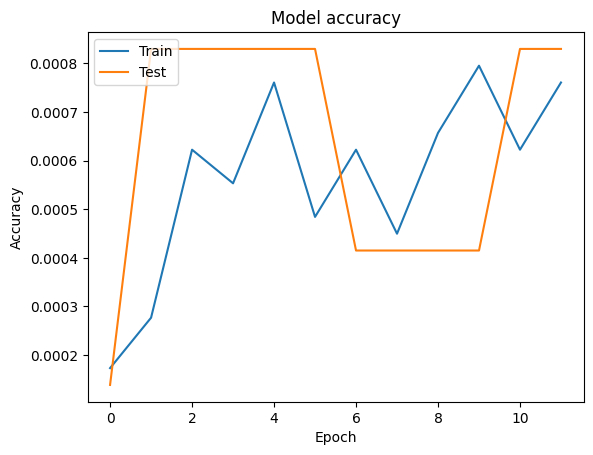

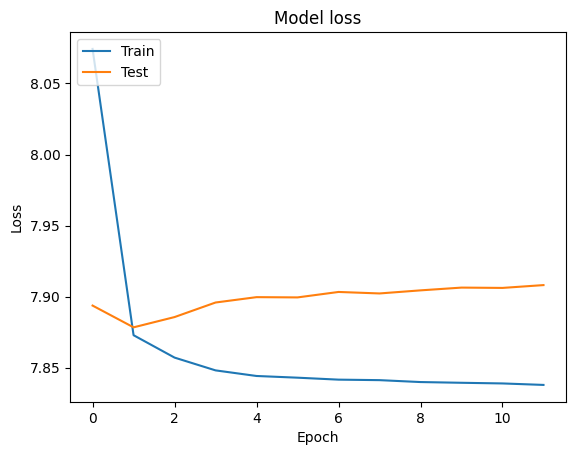

In [23]:
# Separar Características y Etiquetas
X = merged_df.drop(['PrimaryDiagnosisCode'], axis=1)
y = merged_df['PrimaryDiagnosisCode']

# Convertir las etiquetas de string a int
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Preprocesamiento de datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir las etiquetas categóricas a one-hot encoding
y = to_categorical(y)

# División de los Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Definir la entrada
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Resumen del modelo
model.summary()

# Analizar el historial de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


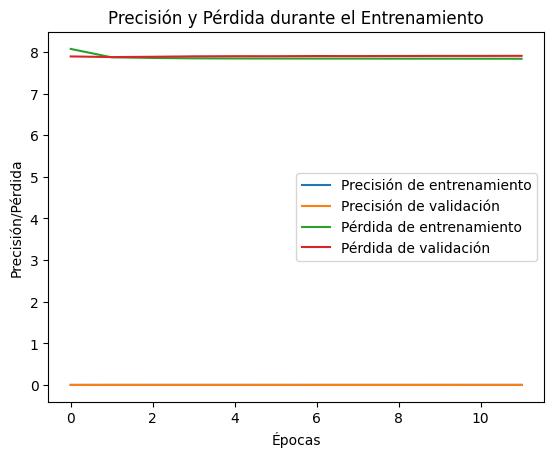

In [24]:
# Precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')

# Pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')

# Títulos y etiquetas
plt.title('Precisión y Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión/Pérdida')
plt.legend()

# Mostrar la gráfica
plt.show()


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 2.7626e-04 - loss: 8.2594 - val_accuracy: 8.2999e-04 - val_loss: 7.8979 - learning_rate: 0.0010
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 4.6859e-04 - loss: 7.8806 - val_accuracy: 8.2999e-04 - val_loss: 7.8791 - learning_rate: 0.0010
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 5.4925e-04 - loss: 7.8571 - val_accuracy: 8.2999e-04 - val_loss: 7.8847 - learning_rate: 0.0010
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 5.6770e-04 - loss: 7.8466 - val_accuracy: 4.1500e-04 - val_loss: 7.8928 - learning_rate: 0.0010
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 7.4284e-04 - loss: 7.8449 - val_accuracy: 4.1500e-04 - val_loss: 7.9006 - learning_rate: 0.0010
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 3.8020e-04 - loss: 7.8416 - val_accuracy: 4.1500e-04 - val_loss: 7.8999 - learning_rate: 0.0010
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2625)           │        86,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 848,069 (3.24 MB)

 Trainable params: 282,689 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 565,380 (2.16 MB)

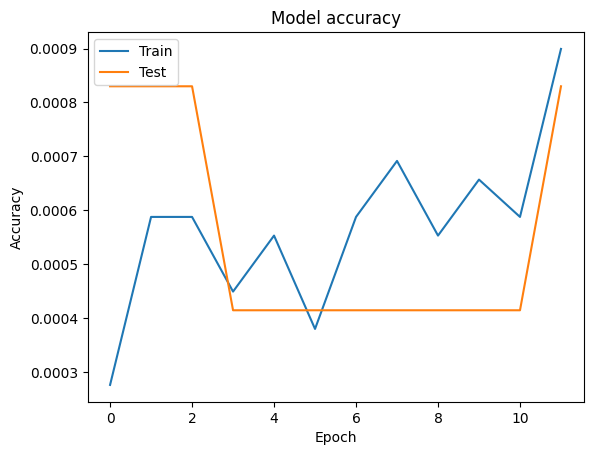

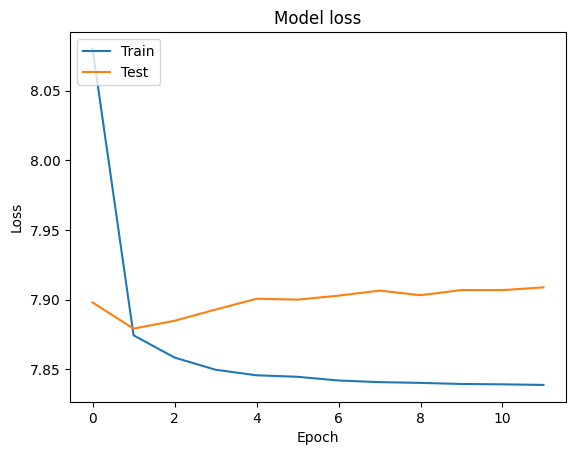

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Función para codificar por frecuencia
class FrequencyEncoder:
    def fit(self, X, y=None):
        self.frequencies = {col: X[col].value_counts().to_dict() for col in X.columns}
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.frequencies[col]).fillna(0)
        return X_transformed

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Separar Características y Etiquetas
X = merged_df.drop(['PrimaryDiagnosisCode'], axis=1)
y = merged_df['PrimaryDiagnosisCode']

# Convertir las etiquetas de string a int
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Convertir las etiquetas a one-hot encoding
y = to_categorical(y)

# Identificar columnas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns

# Decidir qué columnas usar para OneHotEncoder y cuáles para FrequencyEncoder
onehot_cols = [col for col in categorical_cols if X[col].nunique() < 10]  # Ejemplo: columnas con menos de 10 categorías
freq_cols = [col for col in categorical_cols if X[col].nunique() >= 10]

# Crear preprocesador para las columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), onehot_cols),
        ('freq', FrequencyEncoder(), freq_cols)
    ],
    remainder='passthrough'  # Para dejar las columnas numéricas tal cual
)

# Aplicar el preprocesador a los datos
X_transformed = preprocessor.fit_transform(X)

# División de los Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Definir la entrada
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Resumen del modelo
model.summary()

# Analizar el historial de entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [26]:
with open("x_scaler.pkl", "bw") as file:
    pickle.dump(scaler, file)

In [27]:
with open("model_100_tests.pkl", "bw") as file:
    pickle.dump(model, file)